In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from sklearn.metrics import mean_squared_error
import math

# Retrieving the last values

In [52]:
traffic_reel = pd.read_csv('to_predict_traffic.csv', delimiter = ';') # do we want older or more recent data ?
traffic_reel = traffic_reel[traffic_reel["Libelle noeud amont"].isin(['Av_Champs_Elysees-Washington'])]
traffic_reel = traffic_reel[traffic_reel["Libelle noeud aval"].isin(['Av_Champs_Elysees-Berri']) ]
traffic_reel["Date et heure de comptage"] = pd.to_datetime(traffic_reel["Date et heure de comptage"], utc=True)
traffic_reel = traffic_reel[["Date et heure de comptage", "Débit horaire"]].sort_values(by=["Date et heure de comptage"], ascending=True)
traffic_reel = traffic_reel.drop(traffic_reel.index[0])
traffic_reel = traffic_reel.rename(columns={"Débit horaire": "Real Debit"})

traffic_reel


,Date et heure de comptage,Real Debit
276,2023-12-01 00:00:00+00:00,857.0
285,2023-12-01 01:00:00+00:00,685.0
284,2023-12-01 02:00:00+00:00,694.0
40,2023-12-01 03:00:00+00:00,636.0
39,2023-12-01 04:00:00+00:00,438.0
...,...,...
85,2023-12-03 18:00:00+00:00,1464.0
130,2023-12-03 19:00:00+00:00,1385.0
84,2023-12-03 20:00:00+00:00,1200.0
129,2023-12-03 21:00:00+00:00,1266.0


# Creating a Baseline Model

In [4]:
traffic_final_imp = pd.read_csv('traffic_final.csv', delimiter = ',') # do we want older or more recent data ?
traffic_final_imp.head()

,Unnamed: 0,Identifiant arc,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,...,costimestamp_hour,sintimestamp_hour,cos_week,sin_week,cos_weekday,sin_weekday,cos_year_day,sin_year_day,cos_timestamp_hour,sin_timestamp_hour
0,0,4264,AV_Champs_Elysees,2023-02-01T23:00:00+01:00,764.0,11.28000,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,0.866025,-0.500000,0.822984,0.568065,-0.900969,-0.433884,0.852078,0.523416,0.866025,-0.500000
1,1,4264,AV_Champs_Elysees,2023-02-01T22:00:00+01:00,819.0,16.52056,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,...,0.707107,-0.707107,0.822984,0.568065,-0.900969,-0.433884,0.852078,0.523416,0.707107,-0.707107
2,2,4264,AV_Champs_Elysees,2023-02-01T20:00:00+01:00,1082.0,19.98722,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,...,0.258819,-0.965926,0.822984,0.568065,-0.900969,-0.433884,0.852078,0.523416,0.258819,-0.965926
3,3,4264,AV_Champs_Elysees,2023-02-01T18:00:00+01:00,1027.0,23.27334,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,...,-0.258819,-0.965926,0.822984,0.568065,-0.900969,-0.433884,0.852078,0.523416,-0.258819,-0.965926
4,4,191,Sts_Peres,2023-08-10T00:00:00+02:00,257.0,3.04445,Fluide,114,Sts_Peres-Voltaire,119,...,0.866025,-0.500000,-0.748511,-0.663123,-0.900969,-0.433884,-0.788305,-0.615285,0.866025,-0.500000


In [6]:
champs = traffic_final_imp[traffic_final_imp['Libelle'] == "AV_Champs_Elysees"].sort_values(by=["Date et heure de comptage"], ascending=True)
champs.head()

,Unnamed: 0,Identifiant arc,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,...,costimestamp_hour,sintimestamp_hour,cos_week,sin_week,cos_weekday,sin_weekday,cos_year_day,sin_year_day,cos_timestamp_hour,sin_timestamp_hour
7299,7299,4264,AV_Champs_Elysees,2022-11-01T04:00:00+01:00,672.0,8.89223,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,7.071068e-01,0.707107,0.568065,-0.822984,-0.900969,0.433884,0.497513,-0.867456,7.071068e-01,0.707107
7298,7298,4264,AV_Champs_Elysees,2022-11-01T05:00:00+01:00,513.0,7.12889,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,5.000000e-01,0.866025,0.568065,-0.822984,-0.900969,0.433884,0.497513,-0.867456,5.000000e-01,0.866025
7297,7297,4264,AV_Champs_Elysees,2022-11-01T06:00:00+01:00,494.0,6.22500,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,2.588190e-01,0.965926,0.568065,-0.822984,-0.900969,0.433884,0.497513,-0.867456,2.588190e-01,0.965926
8665,8665,4264,AV_Champs_Elysees,2022-11-01T07:00:00+01:00,513.0,5.80723,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,6.123234e-17,1.000000,0.568065,-0.822984,-0.900969,0.433884,0.497513,-0.867456,6.123234e-17,1.000000
7296,7296,4264,AV_Champs_Elysees,2022-11-01T08:00:00+01:00,484.0,5.57111,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,-2.588190e-01,0.965926,0.568065,-0.822984,-0.900969,0.433884,0.497513,-0.867456,-2.588190e-01,0.965926


In [60]:
class BaselineAverage:
    def __init__(self):
        self.average_value = None

    def fit(self, time_series):
        # Calculate the average value of the time series
        self.average_value = time_series.mean()

    def predict(self, forecast_dates):
        # Check if the model has been fitted
        if self.average_value is None:
            raise ValueError("Model has not been fitted. Call fit() first.")

        # Create a DataFrame with forecast dates and corresponding average value predictions
        forecast_df = pd.DataFrame({
            'Date et heure de comptage': forecast_dates,
            'Débit horaire': [self.average_value] * len(forecast_dates)
        })
        forecast_df["Date et heure de comptage"] = pd.to_datetime(forecast_df["Date et heure de comptage"], utc=True)

        return forecast_df

In [61]:
baseline_model = BaselineAverage()
baseline_model.fit(champs['Débit horaire'])

In [90]:
date_range = pd.date_range(start='2023-12-01', end='2023-12-04', freq='H')

formatted_dates = date_range.strftime('%Y-%m-%dT%H:%M:%S%z')

predictions = baseline_model.predict(formatted_dates)

predictions

,Date et heure de comptage,Débit horaire
0,2023-12-01 00:00:00+00:00,884.490328
1,2023-12-01 01:00:00+00:00,884.490328
2,2023-12-01 02:00:00+00:00,884.490328
3,2023-12-01 03:00:00+00:00,884.490328
4,2023-12-01 04:00:00+00:00,884.490328
...,...,...
68,2023-12-03 20:00:00+00:00,884.490328
69,2023-12-03 21:00:00+00:00,884.490328
70,2023-12-03 22:00:00+00:00,884.490328
71,2023-12-03 23:00:00+00:00,884.490328


In [94]:
predictions_without = predictions.drop(predictions.index[-2:])

merged_df = pd.merge(traffic_reel, predictions_without, on='Date et heure de comptage')

# Calculate the Mean Squared Error
mse = mean_squared_error(merged_df['Débit horaire'], merged_df['Real Debit'])
rmse = math.sqrt(mse)
print(rmse)

452.7154091167117


In [86]:
traffic_reel_formatted = traffic_reel.rename(columns={"Real Debit":"Débit horaire"})
reel_values = pd.concat([champs[['Débit horaire', 'Date et heure de comptage']], traffic_reel_formatted], ignore_index=True)
reel_values["Date et heure de comptage"] = pd.to_datetime(results_df["Date et heure de comptage"], utc=True)

reel_values


,Débit horaire,Date et heure de comptage
0,672.0,2022-11-01 03:00:00+00:00
1,513.0,2022-11-01 04:00:00+00:00
2,494.0,2022-11-01 05:00:00+00:00
3,513.0,2022-11-01 06:00:00+00:00
4,484.0,2022-11-01 07:00:00+00:00
...,...,...
9380,1464.0,2023-12-03 18:00:00+00:00
9381,1385.0,2023-12-03 19:00:00+00:00
9382,1200.0,2023-12-03 20:00:00+00:00
9383,1266.0,2023-12-03 21:00:00+00:00


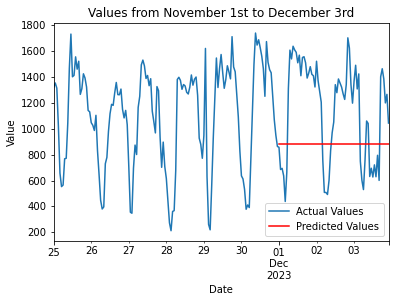

In [93]:
start_date = '2023-11-25'
end_date = '2023-12-04'
df_filtered = reel_values[(reel_values['Date et heure de comptage'] >= start_date) & (reel_values['Date et heure de comptage'] <= end_date)]


ax = df_filtered.plot(x='Date et heure de comptage', y='Débit horaire', kind='line', label='Actual Values', linestyle='-')

predictions_without.plot(x='Date et heure de comptage', y='Débit horaire', kind='line', label='Predicted Values', linestyle='-', color='red', ax=ax)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Values from November 1st to December 3rd')
plt.show()

# Testing an XG Boost Model

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
    cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
    agg.dropna(inplace=True)
    return agg.values